In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [32]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib
import matplotlib.pyplot as plt

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots

# Set up Network

In [ ]:
## Parameters

## task type
task_type='Iris_classification'
# task_type='Regression'

## task matrix X
# M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.03, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
# M_values: np.ndarray = array([0.5, 0., 0., 0.1])

## specify # of nodes
Nin: int = 6
extraNin: int = 0
Ninter: int = 0
Nout: int = 1
extraNout: int = 0

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.25  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
# R_update: str = 'R_propto_dp'
R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
# R_vec_i = 2*array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 1., 2.95, 0.55])
R_vec_i = array([20, 1, 0.5, 10, 2, 1, 0.5, 10, 2, 10, 0.5, 1, 2, 1, 0.5, 1, 2, 1, 0.5])
# R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]
# R_vec_i = np.ones(Nin*Nout + Nin + Nout)

# length of training dataset
iterations = 3200  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
# include_Power: bool = True
include_Power: bool = False
lam = -80**(1)
lam2 = -5*10**(-3)
# lam2 = +10**(-1)  # lambda parameter for penalty on Power dissipation\
# lam = 5.0  # lambda parameter for penalty on Power dissipation

stay_sample: int = 2  # how many loop iterations to stay under the same sampled p
# stay_sample: int = 100

random_state = 37

## Networkx sizes
scale: float = 50.0
squish: float = 0.01

In [ ]:
## User Variables - Keep those since not in use Sep2024

access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [ ]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Ninter, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         include_Power, lam, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(random_state=random_state, M_values=M_values)
Variabs.create_noise_for_extras()

In [ ]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [ ]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

In [ ]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [ ]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
if Ninter >= 1:
    Strctr.build_incidence('partialInter')
else:
    Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [ ]:
## Initiate internal flow network state class

State = Network_State(Variabs)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

In [ ]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

In [ ]:
Strctr.EIEJ_plots

# Train

In [ ]:
import importlib
import Network_State

importlib.reload(Network_State)

In [ ]:
for i in range(Variabs.iterations):
    print('i', i)
    
#     # if i<(200):
#     if i<(iterations/2):
#         pass
#     else:
#         # Variabs.R_update = 'deltaR_propto_Q'
#         Variabs.lam = lam2
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % np.shape(Variabs.X_train)[0] == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)
        print('targets_mat', State.targets_mat)

    # staying stay_sample iteration under same sample
    if use_p_tag and noise_to_extra:
        k = 2*(i//stay_sample) + 1
        if not(i%4):
            k-=1
    elif use_p_tag and not(noise_to_extra):
        k = (i//stay_sample)*2 + i%2
    elif not(use_p_tag) and noise_to_extra:
        k = (i//stay_sample)
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    if not((i+1) % 4):  # add noise only at i=3 etc.
        State.draw_p_in_and_desired(Variabs, k, noise_to_extra=noise_to_extra)  # add noise to extra nodes every 2nd iteration
        State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=noise_to_extra)  # measure and don't change resistances
    else:  # dont add noise to extra nodes
        State.draw_p_in_and_desired(Variabs, k)
        State.solve_flow_given_problem(BigClass, "measure")
        
    print('output-targets', State.output-State.targets_mat)
        
    if include_Power:
        State.calc_Power_norm(BigClass)
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.t += 1
        print('time=', State.t)
        State.calc_loss(BigClass)
        print('loss', State.loss)
        loss_mean = np.mean(np.abs(State.loss), axis=1)
        # Variabs.lam = copy.copy(Variabs.lam) * (10**(-7) / loss_mean) ** 0.001
        if not((i+1) % 4) and access_interNodes:
            print('updating inters')
            State.update_inter_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=True)  # measure and don't change resistances
        else:
            State.update_input_dual(BigClass)
            State.update_output_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
        print('updating Rs')
        State.update_Rs(BigClass)
        # print('Rs', State.R_in_t[-1])
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t) and i>0:
        State.calculate_accuracy_testset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

In [ ]:
State.targets_mat

In [ ]:
loss_mean = np.mean(np.mean(np.abs(State.loss_in_t[-100:]), axis=1))

In [ ]:
np.mean(Variabs.targets)

In [ ]:
final_loss_normalized = loss_mean/np.mean(Variabs.targets)
print('final loss normalized', final_loss_normalized)

# Plots - specific run

### importants + network

In [ ]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

In [ ]:
State.R_in_t

In [ ]:
if np.size(State.Power_norm_in_t)>1:
    plot_functions.plot_Power(State)
else:
    pass

### accuracy

In [ ]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(State.t, State.t_for_accuracy, State.accuracy_in_t, np.shape(Variabs.dataset)[0])
else:
    pass

In [ ]:
Variabs.y_train

## Power of trained network

put a pressure of 1 through all inputs and measure total power dissipation in a trained network that has the state State

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(statistics)

# put pressure of 1 through inputs
State.input_drawn = np.ones(Nin)

# solve flow
State.solve_flow_given_problem(BigClass, "measure")

# measure power
print('u', State.u)
print('Rs', State.R_in_t[-1])
print('Power dissipation', statistics.power_dissip(State.u, State.R_in_t[-1]))

# Save sizes to file

In [ ]:
save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
        
# np.save(save_folder_prelim + 't_2in1out.npy', State.t)
# np.save(save_folder_prelim + 'M_2in1out.npy', M_values)
# np.save(save_folder_prelim + 'output_2in1out_RproptoDeltap.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out_RproptoDeltap.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out_RproptoDeltap.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out_RproptoDeltap.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out_RproptoDeltap.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)
      
# np.save(save_folder_prelim + 'output_2in1out.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)

# loss_mat = np.array([[6.00E-05, 1.20E-03, 2.20E-03, 7.20E-03],[5.00E-05, 0.12, 0.16, 0.15], [2.00E-05, 0.18, 0.16, 0.13], [1.10E-03, 0.049, 0.09, 2.6]])
# np.save(save_folder_prelim + 'loss_mat.npy', loss_mat)

# loss_mat = np.array([[2.8E-13, 9.2E-8, 1.1E-7, 4.3E-5], [7.7E-12, 0.10, 0.18, 0.16], [5.0E-13, 0.15, 0.17, 0.15], [1.2E-7, 0.056, 0.079, 0.068]])
# np.save(save_folder_prelim + 'loss_mat.npy', loss_mat)

# Plots for paper

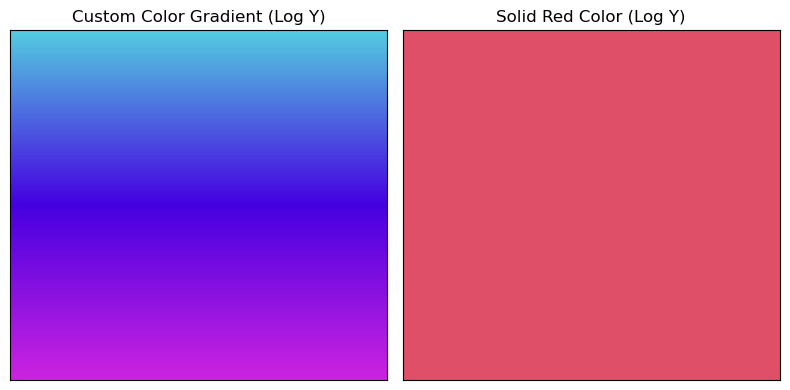

In [58]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom color scheme as a colormap

colors = ['#4500E0', '#54CCE0', '#CD23E1', '#9EE1B1', '#E04F68']
red = '#E04F68'

# Create the custom colormap for the gradient
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [colors[1], colors[0], colors[2]], N=256)

# Create a gradient and plot it with log scale on the y-axis
plt.figure(figsize=(8, 4))

# Generate a vertical gradient and plot with log scale
gradient = np.linspace(0, 1, 256).reshape(256, 1)  # Vertical gradient

# Plot the custom gradient
plt.subplot(1, 2, 1)
plt.imshow(gradient, aspect='auto', cmap=custom_cmap, extent=[0, 1, 1, 256])
# plt.imshow(gradient, cmap=custom_cmap)
plt.title("Custom Color Gradient (Log Y)")
plt.xticks([])  # Remove x ticks
plt.yticks([])  # Remove y ticks

# Plot the solid red block using a 1x1 matrix with the red color mapped
plt.subplot(1, 2, 2)
plt.imshow([[1]], aspect='auto', cmap=LinearSegmentedColormap.from_list('red_cmap', [red, red]), extent=[0, 1, 1, 256])
plt.title("Solid Red Color (Log Y)")
plt.xticks([])  # Remove x ticks
plt.yticks([])  # Remove y ticks

plt.tight_layout()
plt.show()

### Loss afo inputs and outputs

In [59]:
load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/final loss afo Nin Nout normalized loss/10x10/'

loss_mat = np.load(load_folder_prelim + 'loss_mat.npy')

In [60]:
loss_mat

array([[1.43639551e-16, 2.24798319e-08, 2.94676061e-07, 5.95326856e-07,
        8.88770907e-07, 1.55132450e-05, 1.84923205e-04, 5.62119837e-04,
        1.42542094e-03, 2.63469399e-03],
       [1.07212974e-07, 9.34718768e-02, 9.72727421e-02, 8.31333418e-02,
        7.85683070e-02, 9.93994696e-02, 8.13062159e-02, 9.39420230e-02,
        1.13100430e-01, 1.15703573e-01],
       [6.31560681e-08, 5.45471496e-02, 6.41237733e-02, 6.69819588e-02,
        8.75253127e-02, 1.09667304e-01, 1.04407814e-01, 9.56097860e-02,
        1.02809024e-01, 1.12944466e-01],
       [1.36779085e-07, 4.52283665e-02, 8.00714045e-02, 8.01436393e-02,
        9.60590000e-02, 9.03563348e-02, 8.90189923e-02, 9.91768470e-02,
        9.40914928e-02, 1.06199988e-01],
       [1.68356114e-07, 7.19107684e-02, 6.46446549e-02, 8.89540534e-02,
        8.61183326e-02, 8.89415728e-02, 9.26194634e-02, 1.01885795e-01,
        1.03541999e-01, 1.00571318e-01],
       [1.33316255e-07, 2.82882462e-02, 7.77292004e-02, 6.68410226e-02,
   

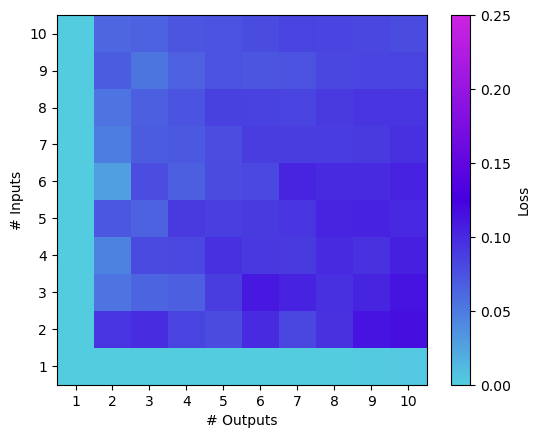

In [61]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.loss_afo_in_out(loss_mat, custom_cmap)

### R change scheme under 2 tasks

In [ ]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/importants_1in2out_n_2in1out/'

t = np.load(load_folder_prelim + 't_1in2out.npy')

loss_1in2out_R_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_RproptoDeltap.npy')
loss_1in2out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoDeltap.npy')
loss_1in2out_propto_Q = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoQ.npy')
loss_1in2out_propto_Power = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoPower.npy')
loss_2in1out_R_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_RproptoDeltap.npy')
loss_2in1out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoDeltap.npy')
loss_2in1out_propto_Q = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoQ.npy')
loss_2in1out_propto_Power = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoPower.npy')

with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    Network_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    Network_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice = pickle.load(f) 

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_compare_R_type_loss(Network_1in2out, Network_2in1out, pos_lattice,
                         loss_1in2out_R_propto_deltap,
                         loss_1in2out_deltaR_propto_deltap,
                         loss_1in2out_propto_Q,
                         loss_1in2out_propto_Power,
                         loss_2in1out_R_propto_deltap,
                         loss_2in1out_deltaR_propto_deltap,
                         loss_2in1out_propto_Q,
                         loss_2in1out_propto_Power)

### 2 Network examples

In [ ]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/inner_variables_2examples/'

t = np.load(load_folder_prelim + 't.npy')
M = np.load(load_folder_prelim + 'M.npy')

output_1in2out = np.load(load_folder_prelim + 'output_1in2out.npy')
input_dual_1in2out = np.load(load_folder_prelim + 'input_dual_1in2out.npy')
output_dual_1in2out = np.load(load_folder_prelim + 'output_dual_1in2out.npy')
R_1in2out = np.load(load_folder_prelim + 'R_1in2out.npy')
loss_1in2out = np.load(load_folder_prelim + 'loss_1in2out.npy')

output_2in1out = np.load(load_folder_prelim + 'output_2in1out.npy')
input_dual_2in1out = np.load(load_folder_prelim + 'input_dual_2in1out.npy')
output_dual_2in1out = np.load(load_folder_prelim + 'output_dual_2in1out.npy')
R_2in1out = np.load(load_folder_prelim + 'R_2in1out.npy')
loss_2in1out = np.load(load_folder_prelim + 'loss_2in1out.npy')
with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    NET_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_1in2out.pkl', 'rb') as f:
    pos_lattice_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    NET_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice_2in1out = pickle.load(f)    

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_performance_2(M, t, output_1in2out, output_2in1out, input_dual_1in2out, input_dual_2in1out, 
                                  output_dual_1in2out, output_dual_2in1out, R_1in2out, R_2in1out, loss_1in2out, loss_2in1out,
                                  NET_1in2out, NET_2in1out, pos_lattice_1in2out, pos_lattice_2in1out)

### different R relations

In [ ]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_final.npy', State.t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_for_accuracy.npy', State.t_for_accuracy)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/accuracy.npy', State.accuracy_in_t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/dataset_len.npy', np.shape(Variabs.dataset)[0])

In [ ]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

In [ ]:
figure_plots.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [ ]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [ ]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [ ]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

In [ ]:
figure_plots.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

## Accuracy classification all materials

In [3]:
t_final = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_after_bug_fix/t.npy')
dataset_shape = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_after_bug_fix/dataset_shape.npy')
t_for_accuracy = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_after_bug_fix/t_for_accuracy.npy')

accuracy_in_t_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_after_bug_fix/R_propto_dpaccuracy_in_t.npy')
accuracy_in_t_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_after_bug_fix/deltaR_propto_dpaccuracy_in_t.npy')
accuracy_in_t_deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_after_bug_fix/deltaR_propto_Qaccuracy_in_t.npy')
accuracy_in_t_deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_after_bug_fix/deltaR_propto_Poweraccuracy_in_t.npy')

In [4]:
accuracy_in_t_R_propto_deltap[:,0] = 1/3
accuracy_in_t_deltaR_propto_deltap[:,0] = 1/3
accuracy_in_t_deltaR_propto_Q[:,0] = 1/3
accuracy_in_t_deltaR_propto_Power[:,0] = 1/3

In [5]:
accuracy_in_t_deltaR_propto_Q

array([[0.33333333, 0.79166667, 0.80833333, ..., 0.725     , 0.9       ,
        0.775     ],
       [0.33333333, 0.8       , 0.79166667, ..., 0.85      , 0.86666667,
        0.84166667],
       [0.33333333, 0.8       , 0.86666667, ..., 0.925     , 0.91666667,
        0.925     ]])

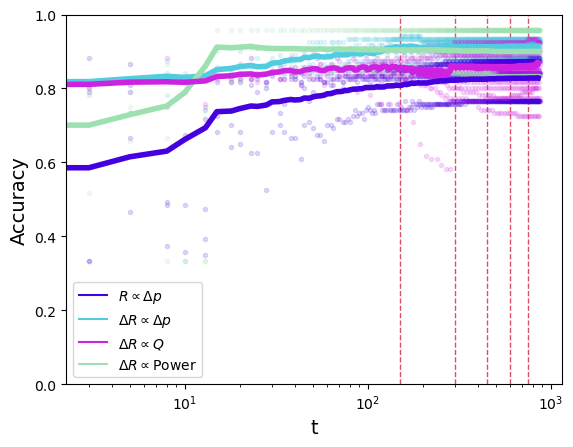

In [35]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)
importlib.reload(statistics)

figure_plots.plot_accuracy_4_materials(t_final, dataset_shape, t_for_accuracy, 
                                       accuracy_in_t_R_propto_deltap,\
                                       accuracy_in_t_deltaR_propto_deltap,\
                                       accuracy_in_t_deltaR_propto_Q,\
                                       accuracy_in_t_deltaR_propto_Power,
                                       smooth=True, window_size=8)

In [ ]:
accuracy_in_t_deltaR_propto_deltap

In [ ]:
accuracy_in_t_R_propto_deltap

## Accuracy classification only R_prop_deltap

In [ ]:
t_final = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification_after_bug_fix_1_material/t.npy')
t_for_accuracy = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification_after_bug_fix_1_material/t_for_accuracy.npy')
accuracy_in_t = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification_after_bug_fix_1_material/accuracy_in_t.npy')
dataset_len = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification_after_bug_fix_1_material/dataset_shape.npy')

In [ ]:
accuracy_in_t[0] = 1/3

In [ ]:
importlib.reload(figure_plots)

figure_plots.plot_accuracy_1_material(t_final, t_for_accuracy, accuracy_in_t, dataset_shape)

## Is the network linear?

In [ ]:
# # put pressure of 1 through 1st input
# State.input_drawn = np.array([1,0])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 1', State.output)
# out1 = State.output

# # put pressure of 1 through 1st input
# State.input_drawn = np.array([0,1])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 2', State.output)
# out2 = State.output

# print('superpose outputs', out1+out2)

# # put pressure of 1 through inputs
# State.input_drawn = np.ones(Nin)

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output both', State.output)

## Statistics

### Error

In [ ]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)